In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu

import gymnax
import optax
import equinox as eqx

import os
import dill
from  functools import partial
import matplotlib.pyplot as plt

from models import NeuralNetwork
from reinforce import train_step, visualize_trajectory

In [3]:
SEED = 3
key_policy, key_train, key_visualize = jr.split(jr.PRNGKey(SEED), 3)

# Get environment params
env, env_params = gymnax.make('Pendulum-v1')
# Make model
policy = NeuralNetwork(input_size=3, output_size=3, width_size=65, depth=1, key=key_policy)
# Split params
start_params, static = eqx.partition(policy, eqx.is_array)
# Training parameters
learning_rate = 5e-3
n_runs = 2000
n_batches = 64
# Setup optimizer
optim = optax.adam(learning_rate)
opt_state = optim.init(start_params)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_debug_infs", True)

keys_train = jr.split(key_train, n_runs)
(trained_params, _), history = jax.lax.scan(
    partial(
        train_step,
        model_static=static,
        env_params=env_params,
        optimizer=optim,
        n_batches=n_batches,
    ),
    (start_params, opt_state),
    keys_train
)

In [4]:
checkpoint_path = "../checkpoints/isolated_training/old_policy.pkl"
if not os.path.exists(os.path.dirname(checkpoint_path)):
    os.mkdir(os.path.dirname(checkpoint_path))

with open(checkpoint_path, 'wb') as file:
    dill.dump(policy, file)           

checkpoint_path = "../checkpoints/isolated_training/new_policy.pkl"
if not os.path.exists(os.path.dirname(checkpoint_path)):
    os.mkdir(os.path.dirname(checkpoint_path))

with open(checkpoint_path, 'wb') as file:
    dill.dump(eqx.combine(trained_params, static), file)           

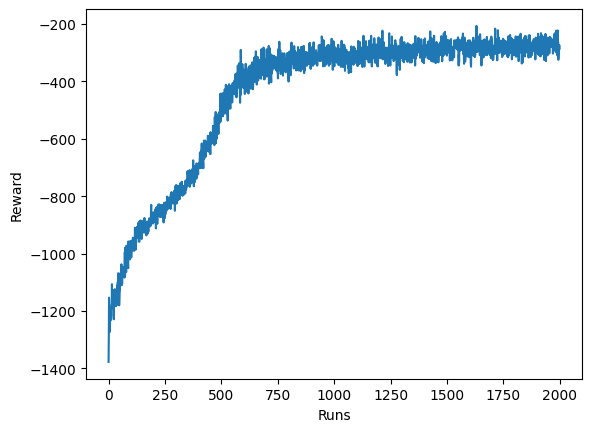

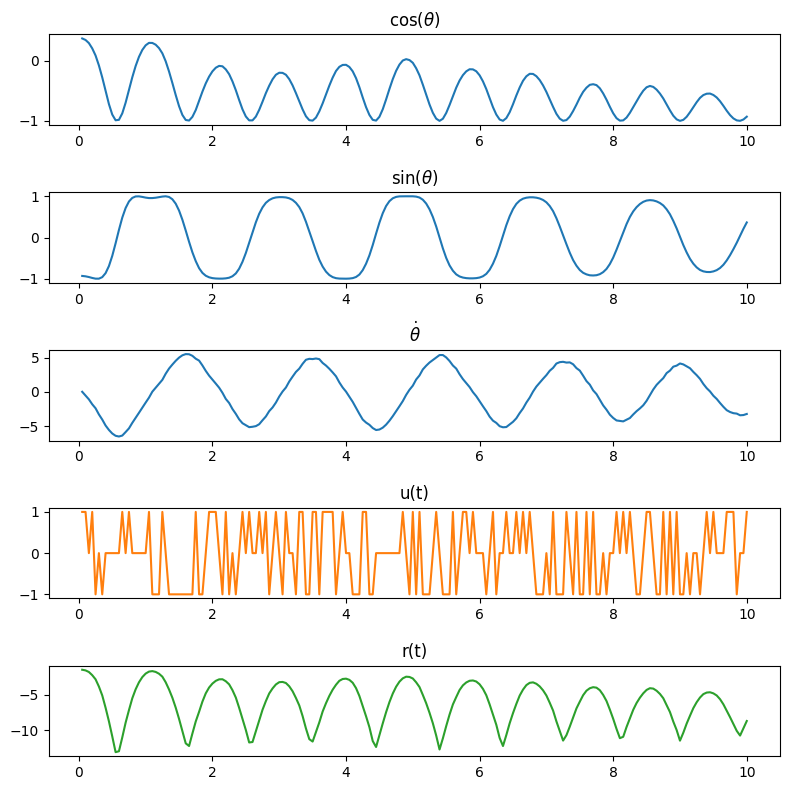

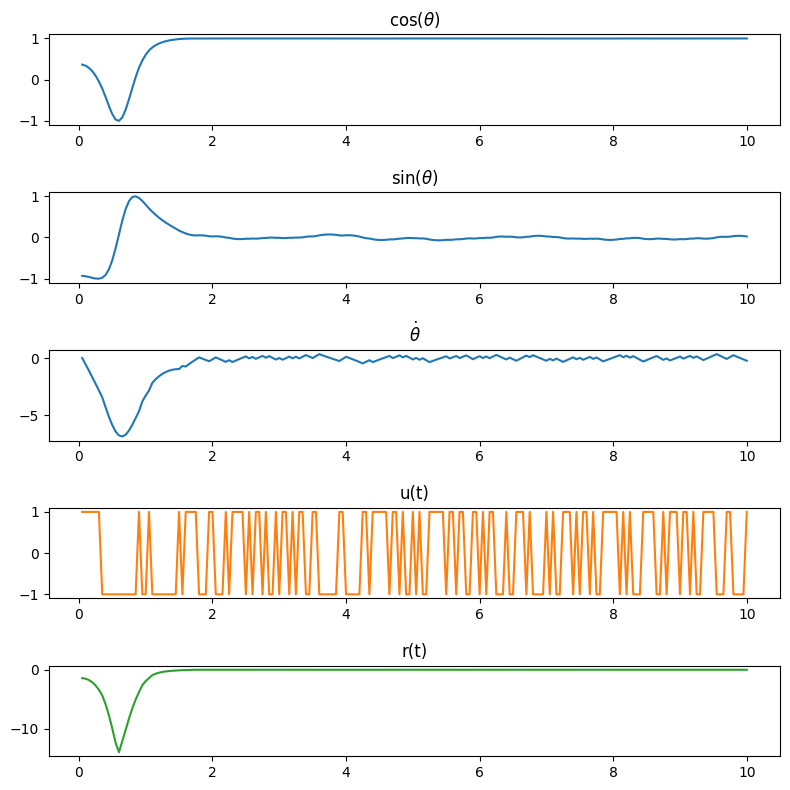

: 

In [5]:
plt.plot(history)
plt.xlabel("Runs")
plt.ylabel("Reward")
visualize_trajectory(eqx.combine(start_params, static), env, env_params, key=key_visualize)
visualize_trajectory(eqx.combine(trained_params, static), env, env_params, key=key_visualize)